In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, multivariate_normal

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

from utils import (select_bands, 
                   select_subset,
                   style,
                   plot_data, 
                   plot_prediction, 
                   plot_uncertainty)

%matplotlib inline

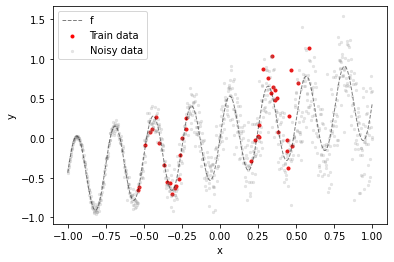

In [2]:
rng = np.random.RandomState(123)

def f(x):
    """Sinusoidal function."""
    return 0.5 * np.sin(25 * x) + 0.5 * x


def noise(x, slope, rng=np.random):
    """Create heteroskedastic noise."""
    noise_std = np.maximum(0.0, x + 1.0) * slope
    return rng.normal(0, noise_std).astype(np.float32)

x = np.linspace(-1.0, 1.0, 1000, dtype=np.float32).reshape(-1, 1)
x_test = np.linspace(-1.5, 1.5, 200, dtype=np.float32).reshape(-1, 1)

# Noisy samples from f (with heteroskedastic noise)
y = f(x) + noise(x, slope=0.2, rng=rng)

# Select data from 2 of 5 bands (regions)
x_bands, y_bands = select_bands(x, y, mask=[False, True, False, True, False])

# Select 40 random samples from these regions
x_train, y_train = select_subset(x_bands, y_bands, num=40, rng=rng)

plot_data(x_train, y_train, x, f(x))
plt.scatter(x, y, **style['bg_data'], label='Noisy data')
plt.legend();

## General kernel regression

... using dual representation of regression model.

In [3]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
        
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [4]:
l = 0.1

K_test = kernel(x_train, x_test, l=l)
K_train = kernel(x_train, x_train, l=l)
K_train_reg_inv = np.linalg.inv(K_train + 0.01 * np.eye(*K_train.shape))

In [5]:
y_exp = K_test.T.dot(K_train_reg_inv).dot(y_train)

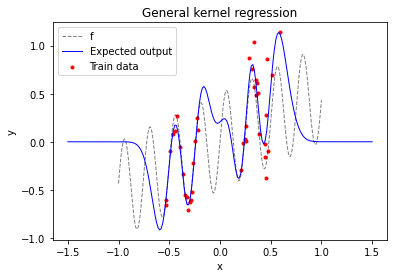

In [6]:
plot_data(x_train, y_train, x, f(x))
plot_prediction(x_test, y_exp)
plt.title('General kernel regression')
plt.legend();

## Nadaraya-Watson kernel regression

In [7]:
# Density function scale
sigma = 0.03

# Marginalized density function
g = norm(loc=0.0, scale=sigma)

# Density function evaluation
d = g.pdf(x_test.T - x_train)

# Kernel evaluation
k = d / (np.sum(d, axis=0))

In [8]:
# Expected output
y_exp = np.sum(k * y_train, axis=0)

# Output variance
y_var = sigma ** 2 + np.sum(k * y_train ** 2, axis=0) - y_exp ** 2

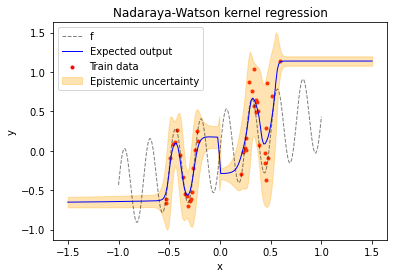

In [9]:
plot_data(x_train, y_train, x, f(x))
plot_prediction(x_test, y_exp, epistemic_uncertainty=np.sqrt(y_var))
plt.title('Nadaraya-Watson kernel regression')
plt.legend();

## Gaussian processes

In [10]:
# Data point dependent noise
noise = np.maximum(0.0, x_train + 1.0) * 0.2
noise = noise.ravel()

rbf = ConstantKernel(1.0) * RBF(length_scale=0.1)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)
#gpr = GaussianProcessRegressor(kernel=rbf, alpha=np.mean(noise)**2)

gpr.fit(x_train, y_train);

In [11]:
# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(x_test, return_cov=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

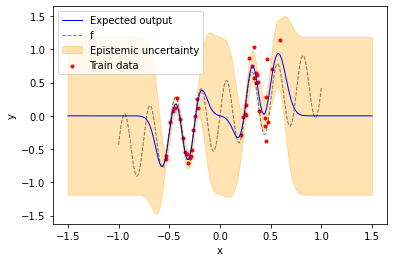

In [12]:
plot_prediction(x_test, mu_s, epistemic_uncertainty=np.sqrt(np.diag(cov_s)))
plot_data(x_train, y_train, x, f(x))
plt.legend();

In [13]:
epsilon = np.eye(mu_s.shape[0]) * 1e-5
mvn = multivariate_normal(mean=mu_s.ravel(), cov=cov_s + epsilon)

In [14]:
samples = mvn.rvs(50)

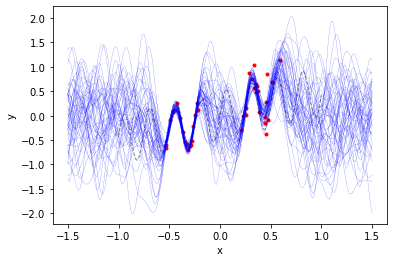

In [15]:
plot_data(x_train, y_train, x, f(x))
for sample in samples:
    plt.plot(x_test, sample, color='b', ls='--', lw=0.2)